In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import scipy.io

# Load the .mat file
file_path = '/Users/rohitviswam/Desktop/IITM Mat file/EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Inspect the structure of the loaded data
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'EV_re_im_split'])

In [3]:
# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
print(EV_data.shape)

(50, 1000, 832)


In [4]:
data = EV_data

In [13]:
import scipy.io
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import xgboost as xgb
from xgboost.callback import TrainingCallback

In [6]:
data=data[0:1,:,:]

In [7]:
data.shape

(1, 1000, 832)

In [8]:
# Function to preprocess the data
def preprocess_data(data, n_timesteps_in, n_timesteps_out):
    X, y = [], []
    for ue in range(data.shape[0]):
        for i in range(data.shape[1] - n_timesteps_in - n_timesteps_out + 1):
            X.append(data[ue, i:i+n_timesteps_in, :])
            y.append(data[ue, i+n_timesteps_in:i+n_timesteps_in+n_timesteps_out, :])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Set parameters for preprocessing
n_timesteps_in = 5
n_timesteps_out = 1

# Preprocess the data
X, y = preprocess_data(data, n_timesteps_in, n_timesteps_out)

# Reshape X and y to fit XGBoost input requirements
X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
y = y.reshape((y.shape[0], y.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
y_test.shape

(199, 832)

In [9]:
# Define a custom callback for tqdm
class TQDMCallback(TrainingCallback):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc='Training XGBoost Model')

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False  # Returning False to indicate no early stopping

    def after_training(self, model):
        self.pbar.close()
        return model  # Return the model as required

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
# Define parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'verbosity': 1
}


In [10]:
# Training with tqdm
num_boost_round = 100
evals = [(dtrain, 'train')]

# Create an instance of TQDMCallback
tqdm_callback = TQDMCallback(total=num_boost_round)

# Train the model
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=evals, verbose_eval=False, callbacks=[tqdm_callback])

Training XGBoost Model: 100%|██████████| 100/100 [1:31:16<00:00, 54.77s/it]


In [11]:
# Make predictions
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [14]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.007767387484566421
Mean Absolute Error (MAE): 0.05525113340368515
R-squared (R2): 0.3932675661209109


In [15]:
# Make predictions
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# Create a DataFrame to tabulate predictions and actual values
results_df = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
})

# Display the first few rows of the DataFrame
print(results_df.head())

     Actual  Predicted
0 -0.046452  -0.049736
1 -0.171510  -0.167320
2 -0.046436  -0.044232
3 -0.199049  -0.197525
4  0.021424   0.028562


In [19]:
# # Optionally, save the results to a CSV file
results_df.to_csv('predictions_vs_actuals.csv', index=False)

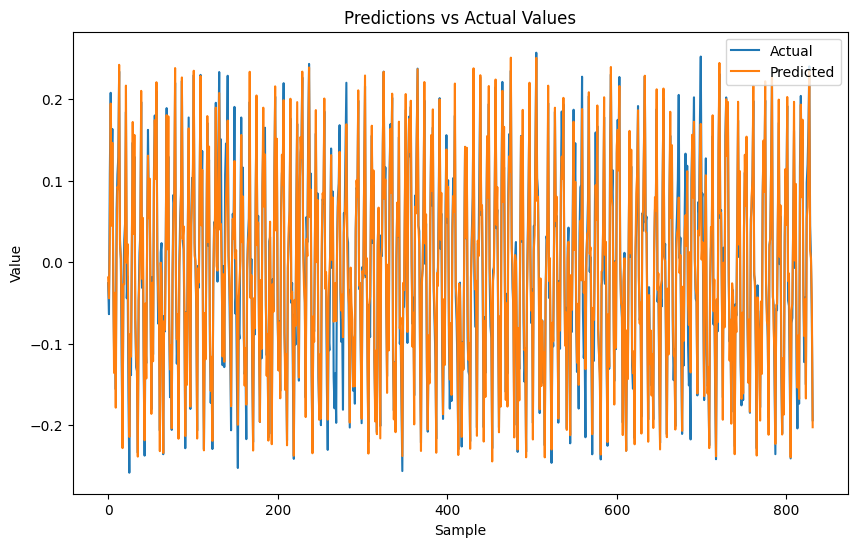

In [29]:
import matplotlib.pyplot as plt

# Make predictions
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[198].flatten(), label='Actual')
plt.plot(y_pred[198].flatten(), label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()


In [30]:
y_test.shape

(199, 832)